# Implementing Support Vector Machine

In this implementation, SVM algorithm is implemented to classify (i) 2D linearly separable data (ii) 2D non-linear data. 

CVXOPT package has been used to solve the convex optimization problem in dual form. 

Data Used:

I have taken the first data (dataX) from Machine Learning Course by Andrew Ng on Coursera. The second data (dataY) I have generated myself through a 2D multivariate gaussian random variable, which is further clustered into two parts using K-means algorithm.

I used following sources to refer to during implementation:

    1. Machine Learning: An Algorithmic Perpective by Stephen Marsland (Primary source)
    2. Machine Learning MOOC on Coursera by Andrew Ng/CS229 (This is also from where I have taken the data used here) 
    3. Neural Networks and Learning Machines (3rd Ed.) by Simon Haykins

### Linearly Separable Data

In [211]:
import numpy as np 
import math 
import operator
import random
import warnings
import scipy.io
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

import cvxopt                                                  # Package for solving convex optimization problem

In [212]:
def generate_MoG_data(num_data, means, covariances, weights):
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)
    return data


init_means = [
    [1, 6.2], # mean of cluster 1
    [6.2, 1], # mean of cluster 2
# mean of cluster 3
]
init_covariances = [
    [[.5, 0.1], [0.1, .5]], # covariance of cluster 1
    [[.8, .2], [.1, .5]], # covariance of cluster 2
 # covariance of cluster 3
]
init_weights = [1/2., 1/2.]  # weights of each cluster

In [213]:
mat = scipy.io.loadmat('ex6data1.mat')      # Taken from Machine Learning Course on Coursera by Andrew Ng
dataX=mat['X']
datX=np.append(dataX,mat['y'],axis=1)

In [214]:
dataY = generate_MoG_data(200, init_means, init_covariances, init_weights)   # Self generated

In [215]:
def kmeans(data, cent_num, maxIter):
    d = np.vstack(data)
    centroid=np.zeros([cent_num,2])
    
    #Following is an alternative initialization, which is random in nature
    
    #for i in range(0,cent_num):
    #    centroid[i][0]=random.randrange(int(min(d[:,0])),int(max(d[:,0])))
    #    centroid[i][1]=random.randrange(int(min(d[:,1])),int(max(d[:,1])))
    
    chosen=np.random.choice(len(data), cent_num, replace=False)
    centroid=[data[x] for x in chosen]
    centroid=np.vstack(centroid)

    assign=np.zeros([len(data),1])  

    for a in range(0,maxIter):
        for i in range(0,len(data)):
            dist=[-1]*cent_num
            for k in range(0,cent_num):
                dist[k]=math.sqrt(math.pow((data[i][0]-centroid[k][0]),2)+math.pow((data[i][1]-centroid[k][1]),2))
            dist_min=dist[0]
            cent=0
            for k in range(1,cent_num):
                if dist[k]<=dist_min:
                    dist_min=dist[k]
                    cent=k
            assign[i]=cent+1

        mean=[[0,0],[0,0]]
        count=[0,0]        

        for k in range(0,len(data)):
            for b in range(0,cent_num):
                if int(assign[k])==b+1:
                    mean[b][0]+=data[k][0]
                    mean[b][1]+=data[k][1]
                    count[b]+=1

        for c in range(0,cent_num): 
            centroid[c][0]=mean[c][0]/count[c]
            centroid[c][1]=mean[c][1]/count[c]
    
    data=np.append(data, assign, axis=1)
    return data, centroid;

In [216]:
datY,c=kmeans(dataY,2,15)     #K-means procedure I have implemented else where

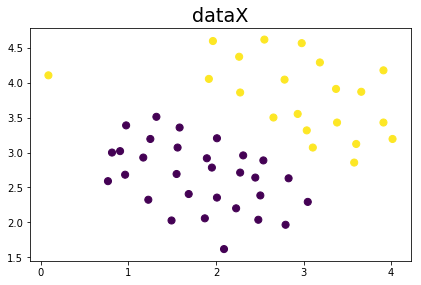

In [217]:
plt.figure()
dX = np.vstack(datX)                         
plt.scatter(dX[:,0], dX[:,1],c=dX[:,2],s=50)
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('dataX')
plt.show()

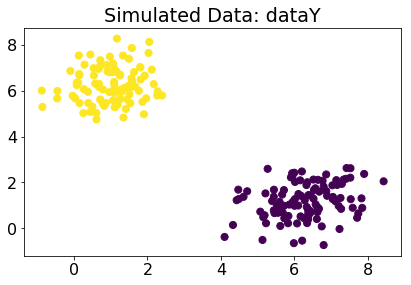

In [218]:
plt.figure()
dY = np.vstack(datY)                          # datY is the clustered version of dataX, after running K-Means Clustering
plt.scatter(dY[:,0], dY[:,1],c=dY[:,2],s=50)
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('Simulated Data: dataY')
plt.show()

In [219]:
dat1=np.matrix(dX)
dat1[:,2][np.where(dat1[:,2]==0)]=-1

dat2=np.matrix(dY)
dat2[:,2][np.where(dat2[:,2]==2)]=-1

In [220]:
# For DataX

# Convex Optmization steps. Here, the matrices needed to be passed onto the QP solver are created and passed to the solver

C=0.025
K=np.dot(dat1[:,(0,1)],dat1[:,(0,1)].T)
P = np.multiply(np.multiply(dat1[:,2],dat1[:,2].T),K)
q = np.matrix(-np.ones((len(dat1),1)))

G = np.concatenate((np.eye(len(dat1)),-np.eye(len(dat1))))
h = np.concatenate((C*np.ones((len(dat1),1)),np.zeros((len(dat1),1))))

A=dat1[:,2].T
b=0.0
solY = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

lambda1X=np.matrix(solY['x'])

wX=np.dot(np.multiply(lambda1X,dat1[:,2]).T,dat1[:,(0,1)])

     pcost       dcost       gap    pres   dres
 0: -6.5091e+00 -2.7995e+00  3e+02  2e+01  7e-15
 1: -8.1503e-01 -2.7409e+00  7e+00  3e-01  6e-15
 2: -6.6540e-01 -1.6666e+00  1e+00  5e-17  1e-15
 3: -7.2663e-01 -8.8506e-01  2e-01  3e-17  1e-15
 4: -7.8580e-01 -8.0618e-01  2e-02  7e-17  9e-16
 5: -7.9438e-01 -7.9640e-01  2e-03  7e-17  1e-15
 6: -7.9530e-01 -7.9533e-01  3e-05  1e-16  1e-15
 7: -7.9532e-01 -7.9532e-01  3e-07  1e-16  1e-15
Optimal solution found.


In [221]:
# Calculatng the intercept for DataX
# Here I have kept the intercept to the average over all the support vectors

sv = np.where(lambda1X>1e-05)[0]
X1 = dat1[sv,0]
X1=np.append(X1,dat1[sv,1],axis=1)
lambdas1 = lambda1X[sv]
targets1 = dat1[sv,2]
bX=np.sum(targets1)
bX-=np.sum(np.multiply(wX[:,0],X1[:,0]))+np.sum(np.multiply(wX[:,1],X1[:,1]))
bX/=len(sv)

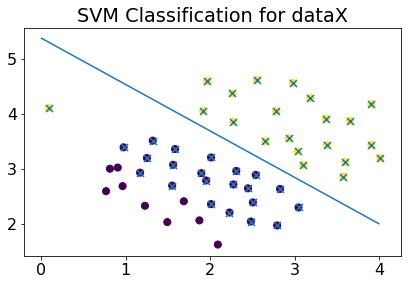

In [222]:
plt.figure()
x=range(0, 5)
y=(-wX[:,0]*x-bX)/wX[:,1]
d = np.vstack(datX)
plt.scatter(d[:,0], d[:,1],s=50,c=d[:,2])
plt.scatter(d[sv,0], d[sv,1],s=50,marker="x")
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('SVM Classification for dataX')
plt.plot(x,y.T)
plt.show()

## Here "x"s represent the support vectors

In [223]:
# For Data Y

# Convex Optmization steps. Here, the matrices needed to be passed onto the QP solver are created and passed to the solver

C=0.025
K=np.dot(dat2[:,(0,1)],dat2[:,(0,1)].T)

P = np.multiply(np.multiply(dat2[:,2],dat2[:,2].T),K)
q = np.matrix(-np.ones((len(dat2),1)))

G = np.concatenate((np.eye(len(dat2)),-np.eye(len(dat2))))
h = np.concatenate((C*np.ones((len(dat2),1)),np.zeros((len(dat2),1))))

A=dat2[:,2].T
b=0.0
solY = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

lambda1Y=np.matrix(solY['x'])

wY=np.dot(np.multiply(lambda1Y,dat2[:,2]).T,dat2[:,(0,1)])

     pcost       dcost       gap    pres   dres
 0: -3.6363e+00 -6.2481e+00  6e+02  2e+01  2e-14
 1: -2.5158e-01 -6.0207e+00  2e+01  4e-01  2e-14
 2: -9.6166e-02 -1.9146e+00  2e+00  3e-02  1e-15
 3: -5.7970e-02 -2.0524e-01  2e-01  1e-03  2e-15
 4: -6.7518e-02 -1.8961e-01  1e-01  1e-03  2e-15
 5: -7.5453e-02 -1.5901e-01  9e-02  5e-04  1e-15
 6: -8.3412e-02 -1.2916e-01  5e-02  2e-04  5e-16
 7: -8.8374e-02 -1.2060e-01  3e-02  8e-05  5e-16
 8: -9.2026e-02 -1.1039e-01  2e-02  2e-05  5e-16
 9: -9.8099e-02 -1.0162e-01  4e-03  6e-17  6e-16
10: -9.9484e-02 -9.9851e-02  4e-04  5e-17  6e-16
11: -9.9634e-02 -9.9681e-02  5e-05  6e-17  6e-16
12: -9.9656e-02 -9.9657e-02  5e-07  7e-17  6e-16
13: -9.9656e-02 -9.9656e-02  5e-09  7e-17  6e-16
Optimal solution found.


In [224]:
# Calculatng the intercept for DataY
# Here I have kept the intercept to the average over all the support vectors

sv = np.where(lambda1Y>1e-05)[0]
X1 = dat2[sv,0]
X1=np.append(X1,dat2[sv,1],axis=1)
lambdas1 = lambda1Y[sv]
targets1 = dat2[sv,2]
bY=np.sum(targets1)
bY-=np.sum(np.multiply(wY[:,0],X1[:,0]))+np.sum(np.multiply(wY[:,1],X1[:,1]))
bY/=len(sv)

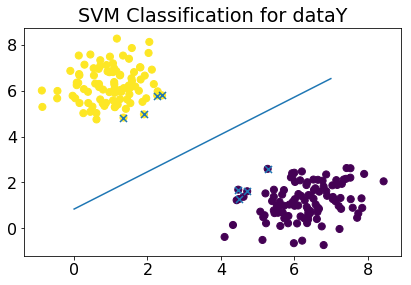

In [225]:
plt.figure()
x=range(0, 8)
y=(-wY[:,0]*x-bY)/wY[:,1]
d = np.vstack(datY)
plt.scatter(d[:,0], d[:,1],s=50,c=d[:,2])
plt.scatter(d[sv,0], d[sv,1],s=50,marker="x")
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('SVM Classification for dataY')
plt.plot(x,y.T)
plt.show()

## Here "x"s represent the support vectors

### Non-linearly separation of data

Here, dataX would be again classified, but this time with non-linear classification.

In [226]:
matN = scipy.io.loadmat('ex6data2.mat')      # Taken from Machine Learning Course on Coursera by Andrew Ng
dataN=matN['X']
datN=np.append(dataN,matN['y'],axis=1)

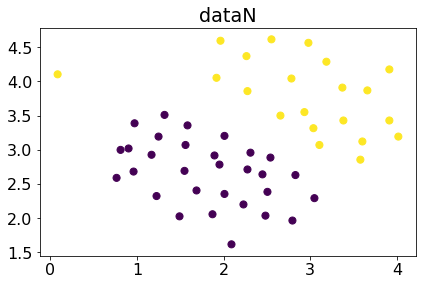

In [227]:
plt.figure()
dN = np.vstack(datX)                         
plt.scatter(dN[:,0], dN[:,1],c=dN[:,2],s=50)
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('dataN')
plt.show()

In [228]:
datN=np.matrix(dN)
datN[:,2][np.where(datN[:,2]==0)]=-1

In [230]:
# For DataN

# Convex Optmization steps. Here, the matrices needed to be passed onto the QP solver are created and passed to the solver

C=0.25
degree=3
sigma=1.
K=np.dot(datN[:,(0,1)],datN[:,(0,1)].T)
#K=np.linalg.matrix_power((1. + 1./sigma*K),3)
K=np.multiply(np.multiply((1. + 1./sigma*K),(1.+1./sigma*K)),(1.+1./sigma*K))
P = np.multiply(np.multiply(datN[:,2],datN[:,2].T),K)
q = np.matrix(-np.ones((len(datN),1)))

G = np.concatenate((np.eye(len(datN)),-np.eye(len(datN))))
h = np.concatenate((C*np.ones((len(datN),1)),np.zeros((len(datN),1))))

A=datN[:,2].T
b=0.0
solN = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

lambda1N=np.matrix(solN['x'])

wN=np.dot(np.multiply(lambda1N,datPhi[:,6]).T,datPhi[:,(0,1,2,3,4,5)])

     pcost       dcost       gap    pres   dres
 0: -5.4388e+00 -1.9263e+01  2e+02  8e+00  2e-12
 1: -2.0495e+00 -1.5048e+01  3e+01  7e-01  2e-12
 2: -1.1477e+00 -5.8614e+00  9e+00  2e-01  9e-13
 3: -3.5908e-01 -1.7377e+00  3e+00  6e-02  4e-13
 4: -4.9390e-02 -4.2163e-01  7e-01  1e-02  3e-13
 5: -4.9746e-03 -4.0084e-02  6e-02  8e-04  4e-14
 6: -4.7004e-03 -9.6713e-03  6e-03  7e-05  7e-15
 7: -6.2722e-03 -7.0670e-03  9e-04  7e-06  6e-15
 8: -6.5697e-03 -6.5825e-03  1e-05  6e-08  7e-15
 9: -6.5749e-03 -6.5750e-03  1e-07  6e-10  7e-15
10: -6.5749e-03 -6.5749e-03  1e-09  6e-12  6e-15
Optimal solution found.


In [231]:
# Calculatng the intercept for DataY
# Here I have kept the intercept to the average over all the support vectors

sv = np.where(lambda1N>1e-05)[0]
X1 = datN[sv,0]
X1=np.append(X1,datN[sv,1],axis=1)
lambdas1 = lambda1N[sv]
targets1 = datN[sv,2]
bN=np.sum(targets1)
for n in range(len(X1)):
    bN-=np.sum(np.multiply(np.multiply(lambdas1,targets1),np.reshape(K[sv[n],sv],(len(X1),1))))
bN/=len(sv)

In [232]:
step=0.01
f0,f1  = np.meshgrid(np.arange(np.min(datN[:,0]), np.max(datN[:,0]), step), np.arange(np.min(datN[:,1]), np.max(datN[:,1]), step))

In [233]:
Y=np.c_[np.ravel(f0), np.ravel(f1)]
K = np.dot(Y,X1.T)
K=np.multiply(np.multiply((1. + 1./sigma*K),(1.+1./sigma*K)),(1.+1./sigma*K))
y = np.zeros((np.shape(Y)[0],1))
for j in range(np.shape(Y)[0]):
    for i in range(len(X1)):
        y[j,0] += lambdas1[i]*targets1[i]*K[j,i]
    y[j,0] += bN

y = y.reshape(f0.shape)
y=np.sign(y)

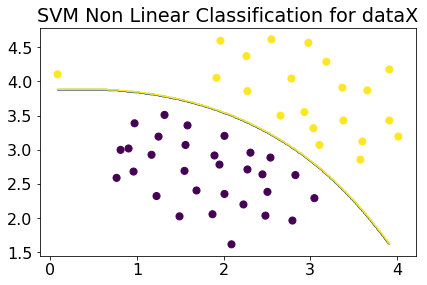

In [234]:
plt.figure()
d = np.vstack(datN)
plt.scatter(dN[:,0], dN[:,1],s=50,c=dN[:,2])
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('SVM Non Linear Classification for dataX')
plt.contour(f0, f1, y,2)
plt.show()